In [419]:
import numpy as np
from scipy.io import loadmat, wavfile
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib as mpl
from Signal_Analysis.features.signal import get_F_0, get_HNR
from importlib import reload
import wave
import json
from vosk import Model, KaldiRecognizer,SetLogLevel
import os.path
import math
from folderFunctions import*


# tools work in progress
import tools
reload(tools)
from tools import *

plt.style.use("dark_background")
mpl.rcParams["lines.linewidth"] = 0.5
plt.close("all")

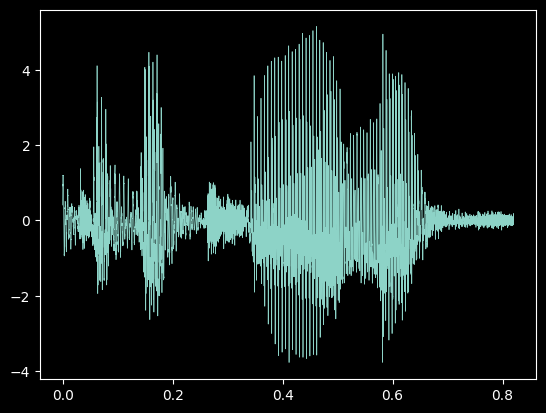

In [420]:
audio_name = "digitala"

Fs,x = wavfile.read(f"test_timestamps/{audio_name}.wav")
x = x/x.std()
tt = np.linspace(0, len(x) / Fs, len(x))

plt.figure()
plt.plot(tt,x)
plt.show()

In [421]:
fl = int(0.09 * Fs)
frames, frames_start = split_frames(x, fl, Fs, overlap=int(7.5 * fl / 8))
tt_frames_center = tt[frames_start] + int(fl/2)/Fs

frame length    : 2880 samples
frame length    : 0.09 seconds
between frames  : 0.006 seconds
number of frames: 145


In [422]:
hnr_frames = []
for f in frames:
    hnr_frames.append(get_HNR(f, Fs, silence_threshold=0.5))
hnr_frames = np.array(hnr_frames)

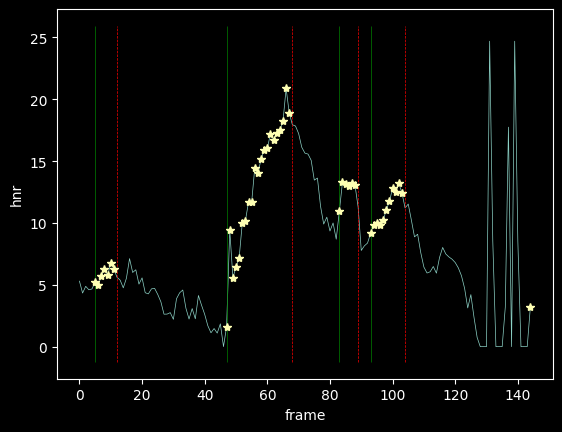

In [423]:
peak_frames = movmean_peak(hnr_frames, lag=3, thr=1, peak_infl=0.3, duration=6)

starts, stops = binary_start_stop(peak_frames)

fn = np.arange(len(hnr_frames))
plt.figure()
plt.plot(fn, hnr_frames, "-")
ymin, ymax = plt.ylim()
plt.vlines(fn[starts], ymin, ymax, colors="g")
plt.vlines(fn[stops], ymin, ymax, colors="r", linestyles="dashed")

plt.xlabel("frame")
plt.ylabel("hnr")

plt.plot(fn[peak_frames], hnr_frames[peak_frames], "*")

plt.show()

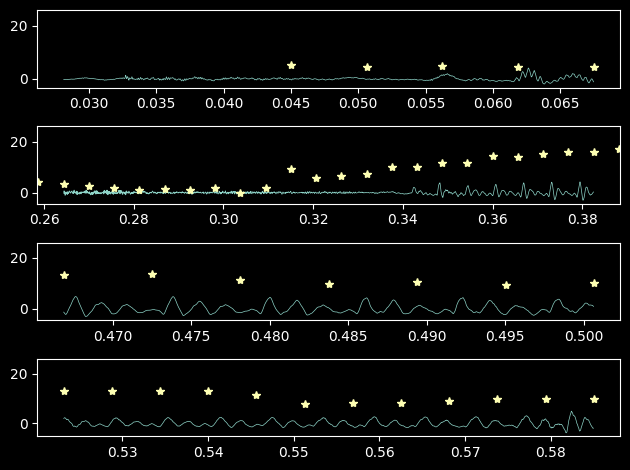

In [424]:
cut_starts = [frames_start[f] for f in starts]
cut_stops = [frames_start[f] for f in stops]

plt.figure()

for i in range(len(cut_starts)):
    x_cut = x[cut_starts[i] : cut_stops[i]]
    wavfile.write(f"output/soft_peak_cut/{audio_name}_{i}.wav", Fs, wavScaler(x_cut))
    plt.subplot(len(cut_starts), 1, i + 1)
    plt.plot(tt[cut_starts[i] : cut_stops[i]], x_cut)
    xmin, xmax = plt.xlim()
    plt.plot(tt_frames_center, hnr_frames,"*")
    plt.xlim(xmin, xmax)

plt.tight_layout()
plt.show()